# Introduction + Set-up

Machine learning has a phenomenal range of application in the health sciences. This tutorial will go over the complete pipeline to build a model that can determine the dementia level of an Alzheimer's patient from their MRI image. This model achieves an a high ROC AUC score.

This tutorial highlights the ease of building a CNN using `tf.keras`. Additionally, TensorFlow 2.3 has new features, including easy data loading utilities that were previously not available in TensorFlow 2.2. We'll be seeing how easy data loading is with these additional features.

We'll be using a GPU accelerator for this NB.

In [8]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\Giacomo Gumierato\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
#pip install tensorflow




  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/80/6f/57d36f6507e432d7fc1956b2e9e8530c5c2d2bfcd8821bcbfae271cd6688/tensorflow-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.14.0-cp311-cp311-win_amd64.whl.metadata (3.3 kB)
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/ad/6e/1bfe367855dd87467564f7bf9fa14f3b17889988e79598bc37bf18f5ffb6/tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata (4.8 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.5.2


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\Giacomo Gumierato\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import kaggledatasets 
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split
import shutil
from glob import glob
from os.path import join
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.14.0


It's always a good idea to set constant variables instead of hard coding numbers into your code. It saves time later when you want to change certain parameters.

In [39]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 40 * strategy.num_replicas_in_sync
IMAGE_SIZE = [128, 128]
EPOCHS = 50

# Data Loading

We'll be using a [Kaggle Alzheimer's dataset](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images) for our tutorial. `tf.keras` has a new preprocessing function that can easily load in images for a directory. In order for this function to work, the data has to be structured in a file directory format.

```
main_directory/
    class1/
        class1_images
    class2/
        class2_images
```

If you input the `main_directory` into the `tf.keras` function, it will figure out the rest!
In our case, the `train` directory is our main directory.

We are also specifying a 80:20 split for our training and validation datasets. To learn more about the importance of having a validation split, check out this [lesson](https://developers.google.com/machine-learning/crash-course/validation/another-partition) from Google's Machine Learning Crash Course.

In [40]:
dataset_path = r"C:\Users\Giacomo Gumierato\Desktop\unipd\anno 5\deeplearning\deeplearningProject\Deep-Learning-project\Dataset"
test_size=0.2
train_path=r'C:\Users\Giacomo Gumierato\Desktop\unipd\anno 5\deeplearning\deeplearningProject\Deep-Learning-project\Dataset\train'
test_path=r'C:\Users\Giacomo Gumierato\Desktop\unipd\anno 5\deeplearning\deeplearningProject\Deep-Learning-project\Dataset\test'
classes = os.listdir(dataset_path)
print(classes)


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [41]:
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
print(classes)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [42]:

for class_name in classes:
    print(class_name)
    class_path = os.path.join(dataset_path, class_name)
    train_class_path = os.path.join(train_path, class_name)
    test_class_path = os.path.join(test_path, class_name)

    # Ottieni la lista di file nella classe
    files = os.listdir(class_path)
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # Dividi il dataset della classe in set di addestramento e test
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

    # Sposta i file di addestramento nella cartella di addestramento
    for file in train_files:
        src_path = os.path.join(class_path, file)
        dst_path = os.path.join(train_path, class_name, file)
        shutil.copy(src_path, dst_path)

    # Sposta i file di test nella cartella di test
    for file in test_files:
        src_path = os.path.join(class_path, file)
        dst_path = os.path.join(test_path, class_name, file)
        shutil.copy(src_path, dst_path)

MildDemented
ModerateDemented
NonDemented
VeryMildDemented


In [43]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5119 files belonging to 4 classes.
Using 4096 files for training.
Found 5119 files belonging to 4 classes.
Using 1023 files for validation.


We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.

In [45]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

# Visualize the data

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.

MildDemented class has 716 samples
ModerateDemented class has 51 samples
NonDemented class has 2560 samples
VeryMildDemented class has 1792 samples


NameError: name 'Image' is not defined

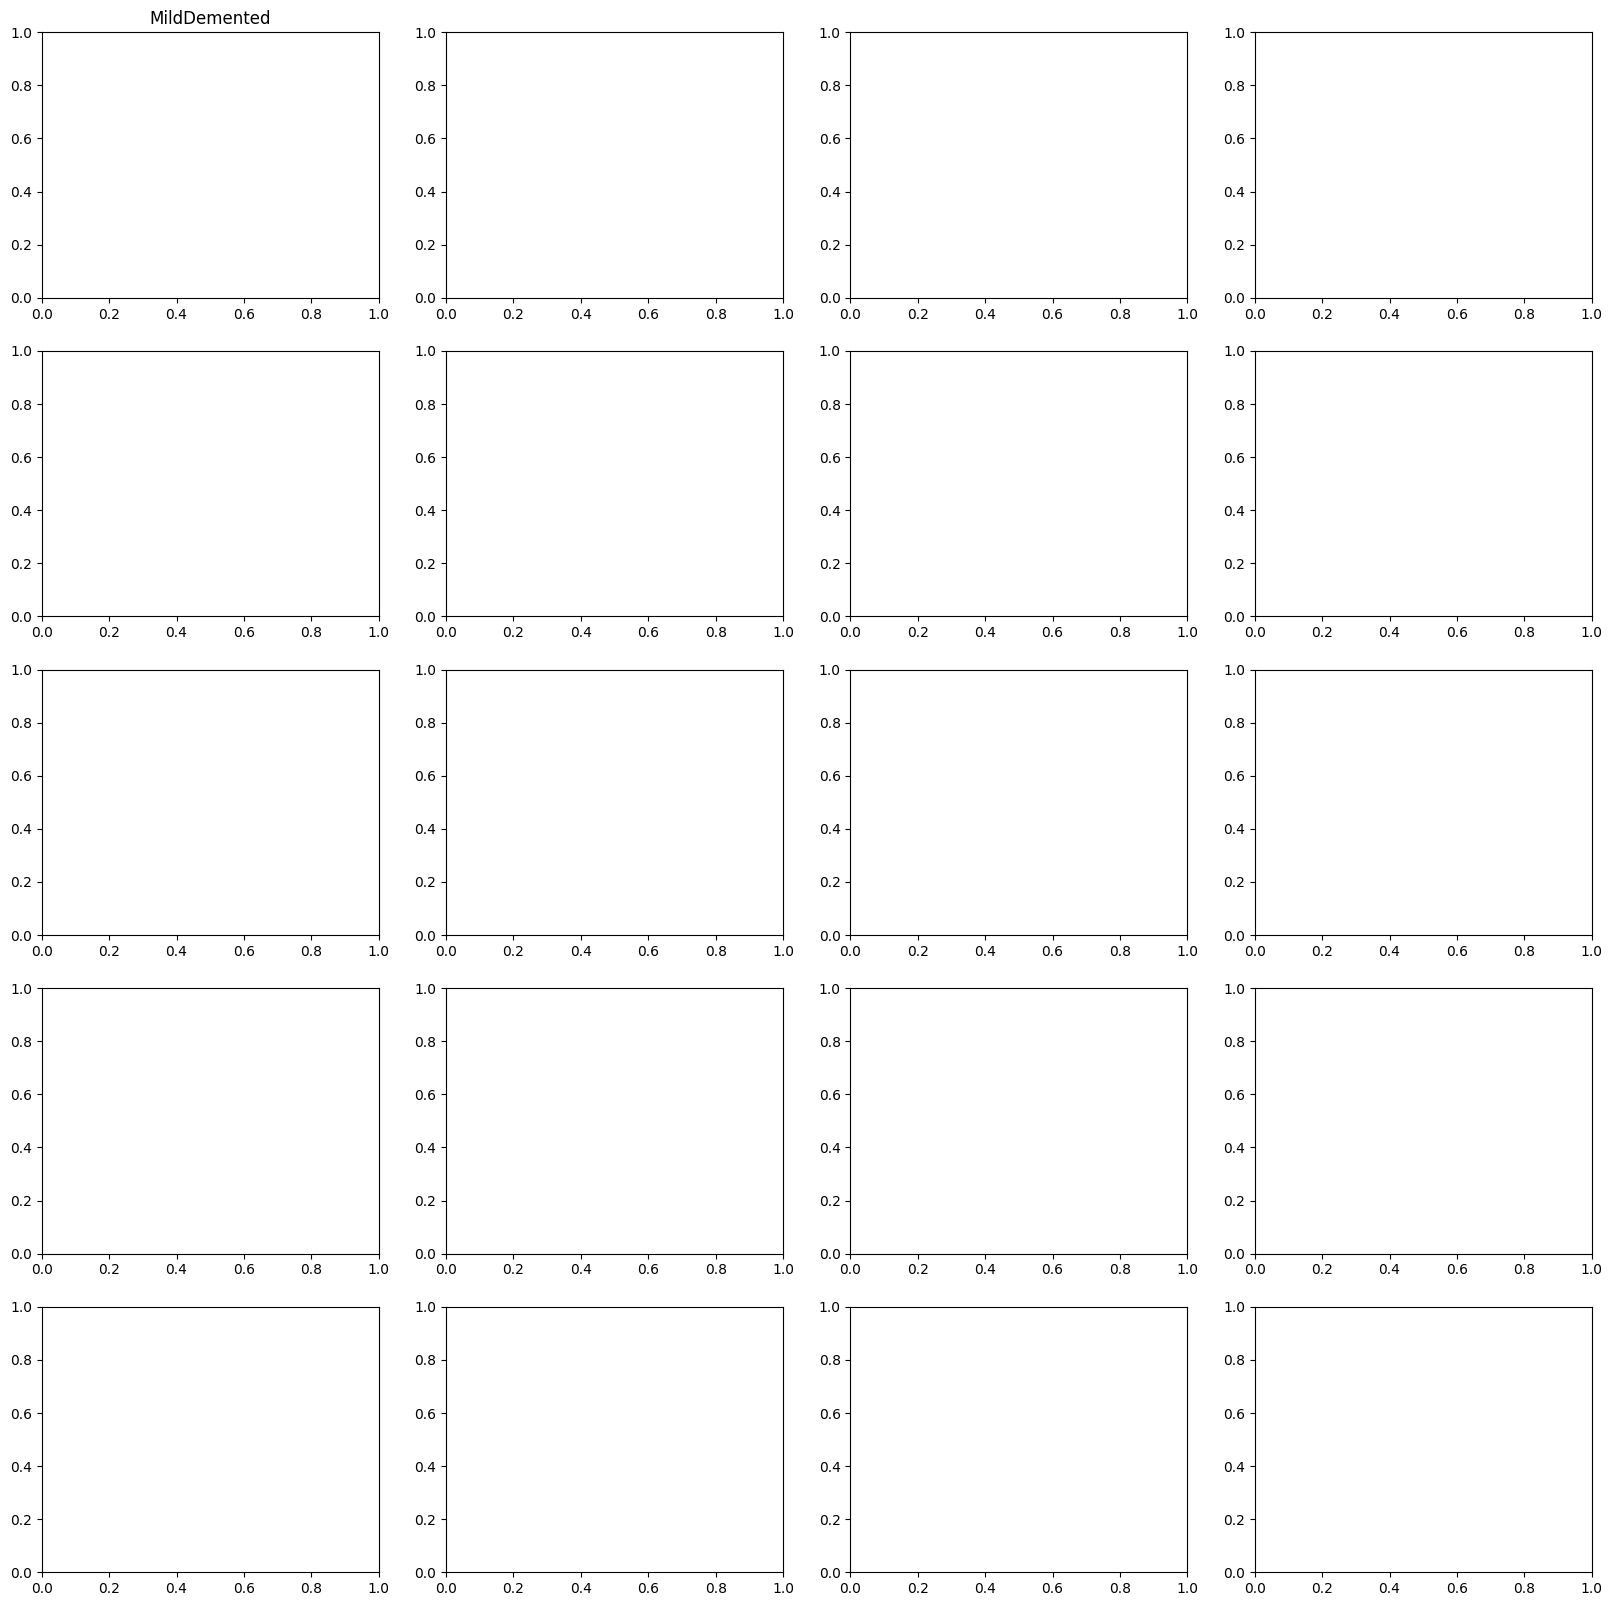

In [48]:
data_folder = train_path


# let's create a dictionary where:
# - keys are folder names (-> the 8 classes)
# - values are the filenames for the files in each folder
imgs = {c: glob(join(data_folder, c, "*")) for c in classes}

for key in imgs.keys():
   print("{} class has {} samples".format(key,len(imgs[key])))

nrows=5

# CHANGE--> PLOT SOME (5) IMAGES PER CLASS ! TO SEE BETTER DIFFERENCES

fig, axs = plt.subplots(nrows=nrows, ncols=len(classes), figsize=(20, 20))

for i,(c,fnames) in enumerate(imgs.items()): # i is the count, images,labels) key and value
    axs[0,i].set_title(c)
    for n in range(nrows):
        fname=(fnames[n]).replace('\\','/')
        im= Image.open(fname)
        axs[n,i].imshow(im)
for ax in axs.flatten():
    ax.axis("off")


#PLOT PER CLASS ☑️
#WE COULD LOOK BETTER AT DATA (ES  HISTOGRAMS,STATISTICS) (Lesson 8) (look unbalance)

# code: per class visualization (Hyun)
train_labels = np.concatenate([y for _, y in tqdm(train_ds)], axis=0)
val_labels = np.concatenate([y for _, y in tqdm(val_ds)], axis=0)
train_labels = [train_ds.class_names[idx] for idx in train_labels]
val_labels = [val_ds.class_names[idx] for idx in val_labels]

vis_ratio = False # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', title=vis_title, rot=45)
plt.legend(['train', 'validation'])


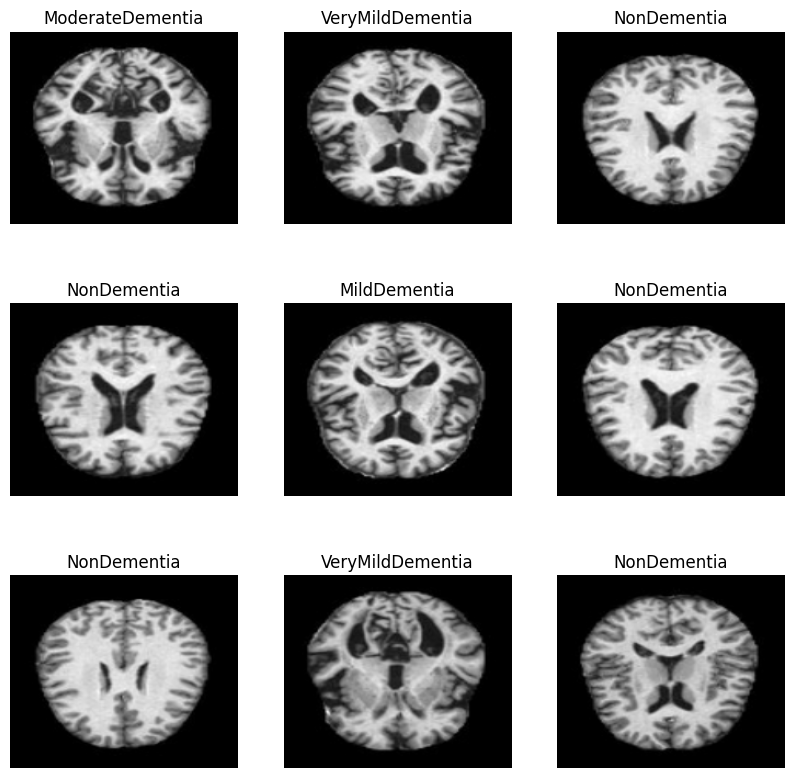

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[(labels[i])])
    plt.axis("off")

# Feature Engineering

Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering. Learn more about feature engineering [here](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering).

In [9]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

The following cell makes calling images from our dataset more efficient.

In [10]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Deciding a Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.

In [11]:
NUM_IMAGES = []

for label in class_names:
    dir_name = 'C:/Users/Giacomo Gumierato/Desktop/unipd/anno 5/deeplearning/deeplearningProject/Deep-Learning-project/Dataset/train/' + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [13]:
NUM_IMAGES

[716, 51, 2560, 1792]

Our dataset is not balanced, so we cannot use accuracy as our metric. For this tutorial, we will be using ROC AUC. Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is pretty much random. Learn more about ROC AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

# Build the ML Model

We'll be using the same architecture for our model as my [Pneumonia Classification NB](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#4.-Build-the-CNN). Using `tf.keras`, we can easily build up the layers of our CNN.

In [14]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [15]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [19]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

# Training the Model

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate) is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

In [20]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

Let's fit our model!

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/30
256/256 [==============================] - 168s 657ms/step - loss: 0.9520 - auc: 0.8202 - val_loss: 49.6511 - val_auc: 0.3386 - lr: 0.0100
Epoch 2/30
256/256 [==============================] - 168s 655ms/step - loss: 0.9464 - auc: 0.8201 - val_loss: 0.9146 - val_auc: 0.8306 - lr: 0.0089
Epoch 3/30
256/256 [==============================] - 169s 658ms/step - loss: 0.9481 - auc: 0.8208 - val_loss: 1.2400 - val_auc: 0.5824 - lr: 0.0079
Epoch 4/30
256/256 [==============================] - 168s 655ms/step - loss: 0.9277 - auc: 0.8294 - val_loss: 1.1853 - val_auc: 0.6475 - lr: 0.0071
Epoch 5/30
256/256 [==============================] - 168s 655ms/step - loss: 0.9264 - auc: 0.8302 - val_loss: 1.0088 - val_auc: 0.7881 - lr: 0.0063
Epoch 6/30
256/256 [==============================] - 168s 656ms/step - loss: 0.9235 - auc: 0.8311 - val_loss: 1.4659 - val_auc: 0.8114 - lr: 0.0056
Epoch 7/30
256/256 [==============================] - 167s 654ms/step - loss: 0.9138 - auc: 0.8349 - val_

# Visualize Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

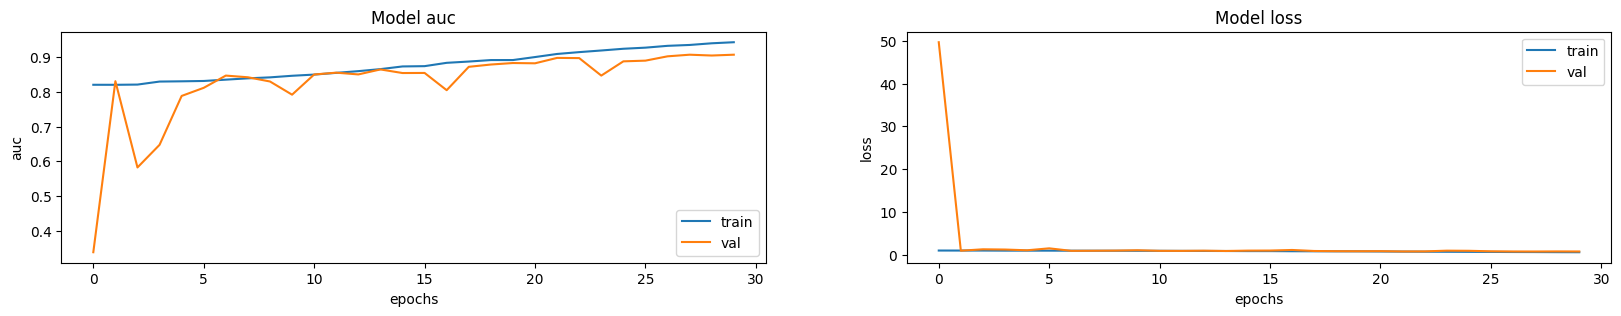

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Evaluate the Model

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [25]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\Giacomo Gumierato\Desktop\unipd\anno 5\deeplearning\deeplearningProject\Deep-Learning-project\Dataset\test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1281 files belonging to 4 classes.


In [26]:
_ = model.evaluate(test_ds)

43/43 [==============================] - 11s 249ms/step - loss: 0.6740 - auc: 0.9200
